In [2]:
import pandas as pd
import gzip
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

/home/ss/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df_video = getDF('Digi_Mus.json.gz')
df_video = df_video[0:30000]

In [5]:
#fill each NA with 0
df_video = df_video.fillna(0)

In [6]:
#getting number of helpful votes out of combination of helpful and overall votes
df_video['vote_helpful'] = df_video.helpful.apply(lambda val: val[0])

In [7]:
#getting number of overall votes out of combination of helpful and overall votes
df_video['vote_overall'] = df_video.helpful.apply(lambda val: val[1])

In [8]:
#helpful percent obtained by diving helpful votes by overall votes
df_video['help_percent'] = df_video['vote_helpful']/df_video['vote_overall']

In [9]:
#if percentage of helpfulness is greater than .75, the review is considered to be helpful
df_video['review_helpful'] = np.where((df_video.help_percent > .75), "Yes", "No")

In [10]:
df_video.shape

(30000, 13)

In [11]:
#textblob is used to get polarity. Polarity tells sentiment of the sentence. (-) value indicates negative review and (+) value indicate positive review
df_video['polarity'] = df_video['reviewText'].apply(lambda val: TextBlob(val).sentiment.polarity)

In [12]:
df_video['sentiment'] = np.where((df_video.polarity > 0.1), "Positive", "Negative")

In [13]:
df_video = df_video.fillna(0)
df_video = shuffle(df_video)
df_video[0:1]

,reviewerID,asin,reviewerName,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,vote_helpful,vote_overall,help_percent,review_helpful,polarity,sentiment
12936,AWUMLV72KTL8O,B000002HAH,kabalabonga,"[1, 1]",1268006400,Suggestive lyrics. Explicit lyrics. Lyrics en ...,5.0,"03 8, 2010",Levitating Me for over 20 years,1,1,1.0,Yes,0.072917,Negative


In [14]:
df_video['sentiment'].value_counts()

Positive    26018
Negative     3982
Name: sentiment, dtype: int64

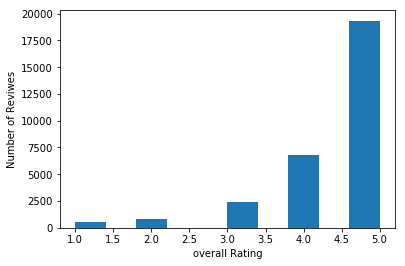

In [15]:
#Plots
plt.hist(df_video.overall)
plt.xlabel('overall Rating')
plt.ylabel('Number of Reviwes')
plt.show()

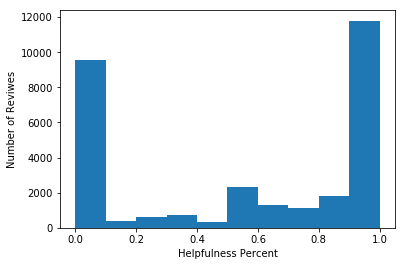

In [16]:
plt.hist(df_video.help_percent)
plt.xlabel('Helpfulness Percent')
plt.ylabel('Number of Reviwes')
plt.show()

In [17]:
df_video['review_helpful'].value_counts()

No     16253
Yes    13747
Name: review_helpful, dtype: int64

In [18]:
pos_cnt = 0
neg_cnt = 0
x = []
y = []
data_len = df_video.shape[0]
for i in range(data_len):
    if (df_video.review_helpful[i] == "Yes"):   
        if (df_video.sentiment[i] == ('Positive')): 
             pos_cnt = pos_cnt + 1
        else:
             neg_cnt = neg_cnt + 1
        
y.append(pos_cnt)
y.append(neg_cnt)
x.append('1')
x.append('0')
print('NUmber of reviews which are helpful and positive', pos_cnt)
print('NUmber of reviews which are helpful and negative', neg_cnt)

('NUmber of reviews which are helpful and positive', 12378)
('NUmber of reviews which are helpful and negative', 1369)


In [19]:
pos_cnt = 0
neg_cnt = 0
x = []
y = []
data_len = df_video.shape[0]
for i in range(data_len):
    if (df_video.review_helpful[i] == "No"):   
        if (df_video.sentiment[i] == ('Positive')): 
             pos_cnt = pos_cnt + 1
        else:
             neg_cnt = neg_cnt + 1
        
y.append(pos_cnt)
y.append(neg_cnt)
x.append('1')
x.append('0')
print('NUmber of reviews which are not helpful and positive', pos_cnt)
print('NUmber of reviews which are not helpful and negative', neg_cnt)

('NUmber of reviews which are not helpful and positive', 13640)
('NUmber of reviews which are not helpful and negative', 2613)


# Infer sentiment from review

In [20]:
tr_x, ts_x, tr_y, ts_y = train_test_split(df_video['reviewText'], df_video['sentiment'], test_size=0.2, random_state=0)
print ts_x.shape

(6000,)


In [21]:
vectorizer = TfidfVectorizer(norm = 'l2',min_df = 0, use_idf = True, smooth_idf = False, sublinear_tf = True)
tr_x_fit = vectorizer.fit_transform(tr_x)
ts_x_fit = vectorizer.transform(ts_x)
print(ts_x_fit.shape)

(6000, 67030)


# Logistic Regression

In [22]:
cls = LogisticRegression()

#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)

#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
print('Accuracy of prediction - Logistic Regression', accuracy_score(ts_y, pred))

('cross_validation scores', array([ 0.87694444,  0.88472222,  0.87736111,  0.87944444,  0.88097222]))
('Accuracy of prediction - Logistic Regression', 0.88683333333333336)


/home/ss/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


# Naive Bayes

In [23]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [24]:
cls = MultinomialNB()
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - NaiveBayes', round(acc,2))

('cross_validation scores', array([ 0.86444444,  0.87347222,  0.86541667,  0.86763889,  0.86930556]))
('Accuracy of prediction - NaiveBayes', 86.7)


# Decision Tree

In [25]:
from sklearn import tree
cls = tree.DecisionTreeClassifier()
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Decision Tree', round(acc,2))

('cross_validation scores', array([ 0.83625   ,  0.83277778,  0.82930556,  0.82805556,  0.82847222]))
('Accuracy of prediction - Decision Tree', 83.07)


# Adaboost classifier

In [28]:
from sklearn.ensemble import AdaBoostClassifier
cls = AdaBoostClassifier(n_estimators=100)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Adaboost', round(acc,2))

('cross_validation scores', array([ 0.89263889,  0.90208333,  0.90652778,  0.89208333,  0.89083333]))
('Accuracy of prediction - Adaboost', 89.93)


# RandomClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators=10)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - RanDomForest', round(acc,2))

('cross_validation scores', array([ 0.86944444,  0.87388889,  0.87097222,  0.86819444,  0.86361111]))
('Accuracy of prediction - RanDomForest', 87.23)


# Multilayer perceptron

In [26]:
from sklearn.neural_network import MLPClassifier
cls = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(120, 120), random_state=1)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Multilayer Perceptron', round(acc,2))

('cross_validation scores', array([ 0.90902778,  0.91083333,  0.90986111,  0.90944444,  0.90916667]))
('Accuracy of prediction - Multilayer Perceptron', 91.25)


In [27]:
from sklearn.neural_network import MLPClassifier
cls = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10), random_state=1)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Multilayer Perceptron', round(acc,2))

('cross_validation scores', array([ 0.89680556,  0.90875   ,  0.90791667,  0.90972222,  0.90847222]))
('Accuracy of prediction - Multilayer Perceptron', 90.97)


In [28]:
from sklearn.neural_network import MLPClassifier
cls = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10), random_state=1)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Multilayer Perceptron', round(acc,2))

('cross_validation scores', array([ 0.90902778,  0.90916667,  0.90944444,  0.90888889,  0.90625   ]))
('Accuracy of prediction - Multilayer Perceptron', 91.47)


In [29]:
from sklearn.neural_network import MLPClassifier
cls = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(120), random_state=1)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Multilayer Perceptron', round(acc,2))

('cross_validation scores', array([ 0.90930556,  0.90819444,  0.90888889,  0.90944444,  0.90861111]))
('Accuracy of prediction - Multilayer Perceptron', 91.33)


In [30]:
from sklearn.neural_network import MLPClassifier
cls = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,10,10), random_state=1)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Multilayer Perceptron', round(acc,2))

('cross_validation scores', array([ 0.90638889,  0.91138889,  0.90986111,  0.91027778,  0.90666667]))
('Accuracy of prediction - Multilayer Perceptron', 91.18)


In [31]:
from sklearn.neural_network import MLPClassifier
cls = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(120,120,120), random_state=1)
#CROSS VALIDATION
cv1 = ShuffleSplit(n_splits=5, test_size = 0.3, random_state=0)
scores = cross_val_score(cls, tr_x_fit, tr_y, cv=cv1)
print ('cross_validation scores', scores)
#
cls.fit(tr_x_fit, tr_y)
pred = cls.predict(ts_x_fit)
ts_y = np.reshape(ts_y, (-1,1))
pred = np.reshape(pred, (-1,1))
acc = accuracy_score(ts_y, pred)*100
print('Accuracy of prediction - Multilayer Perceptron', round(acc,2))

('cross_validation scores', array([ 0.90763889,  0.9125    ,  0.91      ,  0.90847222,  0.90527778]))
('Accuracy of prediction - Multilayer Perceptron', 91.77)
